### **Import Libraries**

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress all logs except warnings
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from ngboost import NGBClassifier
from snapml import BoostingMachineClassifier
from tab_transformer_pytorch import TabTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from ray import tune
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, ClassifierMixin

### **Load & Split Data**

In [10]:
df = pd.read_csv("../data/cleaned_data.csv")
df = df.iloc[:, :]

print('Sample Data')
display(df.head())

Sample Data


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,0,0,0,0,1,0
1,55,0,156,85.0,140,90,2,0,0,0,1,1
2,51,0,165,64.0,130,70,2,0,0,0,0,1
3,48,1,169,82.0,150,100,0,0,0,0,1,1
4,60,0,151,67.0,120,80,1,1,0,0,0,0


In [11]:
df = df.loc[:, ['age', 'gender', 'height','weight','ap_hi', 'ap_lo', 'cholesterol', 
                'gluc', 'smoke', 'alco', 'active', 'cardio' 
                ]]
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,0,0,0,0,1,0
1,55,0,156,85.0,140,90,2,0,0,0,1,1
2,51,0,165,64.0,130,70,2,0,0,0,0,1
3,48,1,169,82.0,150,100,0,0,0,0,1,1
4,60,0,151,67.0,120,80,1,1,0,0,0,0


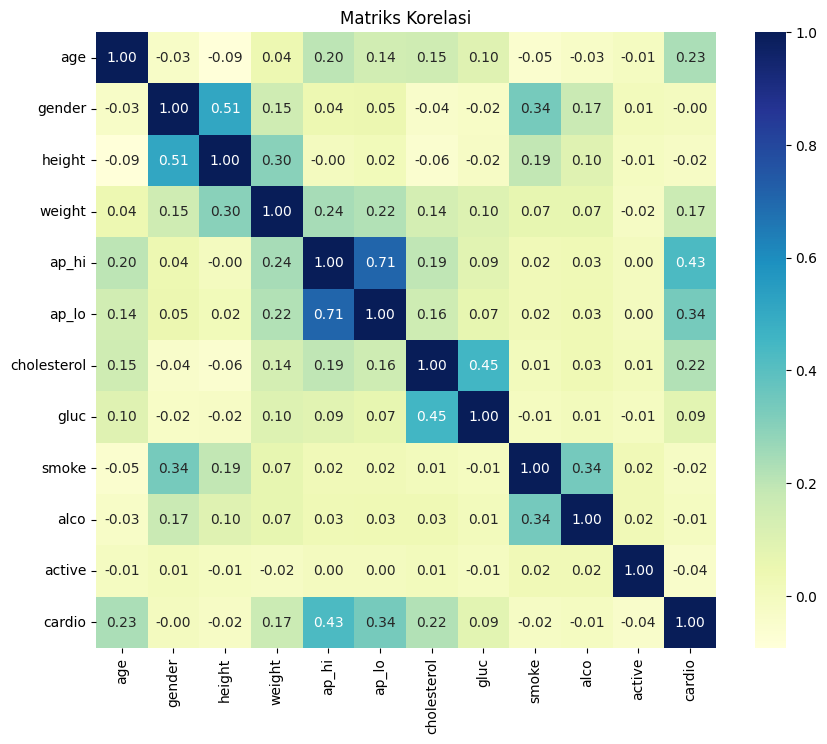

In [ ]:
correlations = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Matriks Korelasi")
plt.show()

In [14]:
X = df.drop('cardio', axis=1)  
y = df['cardio']   

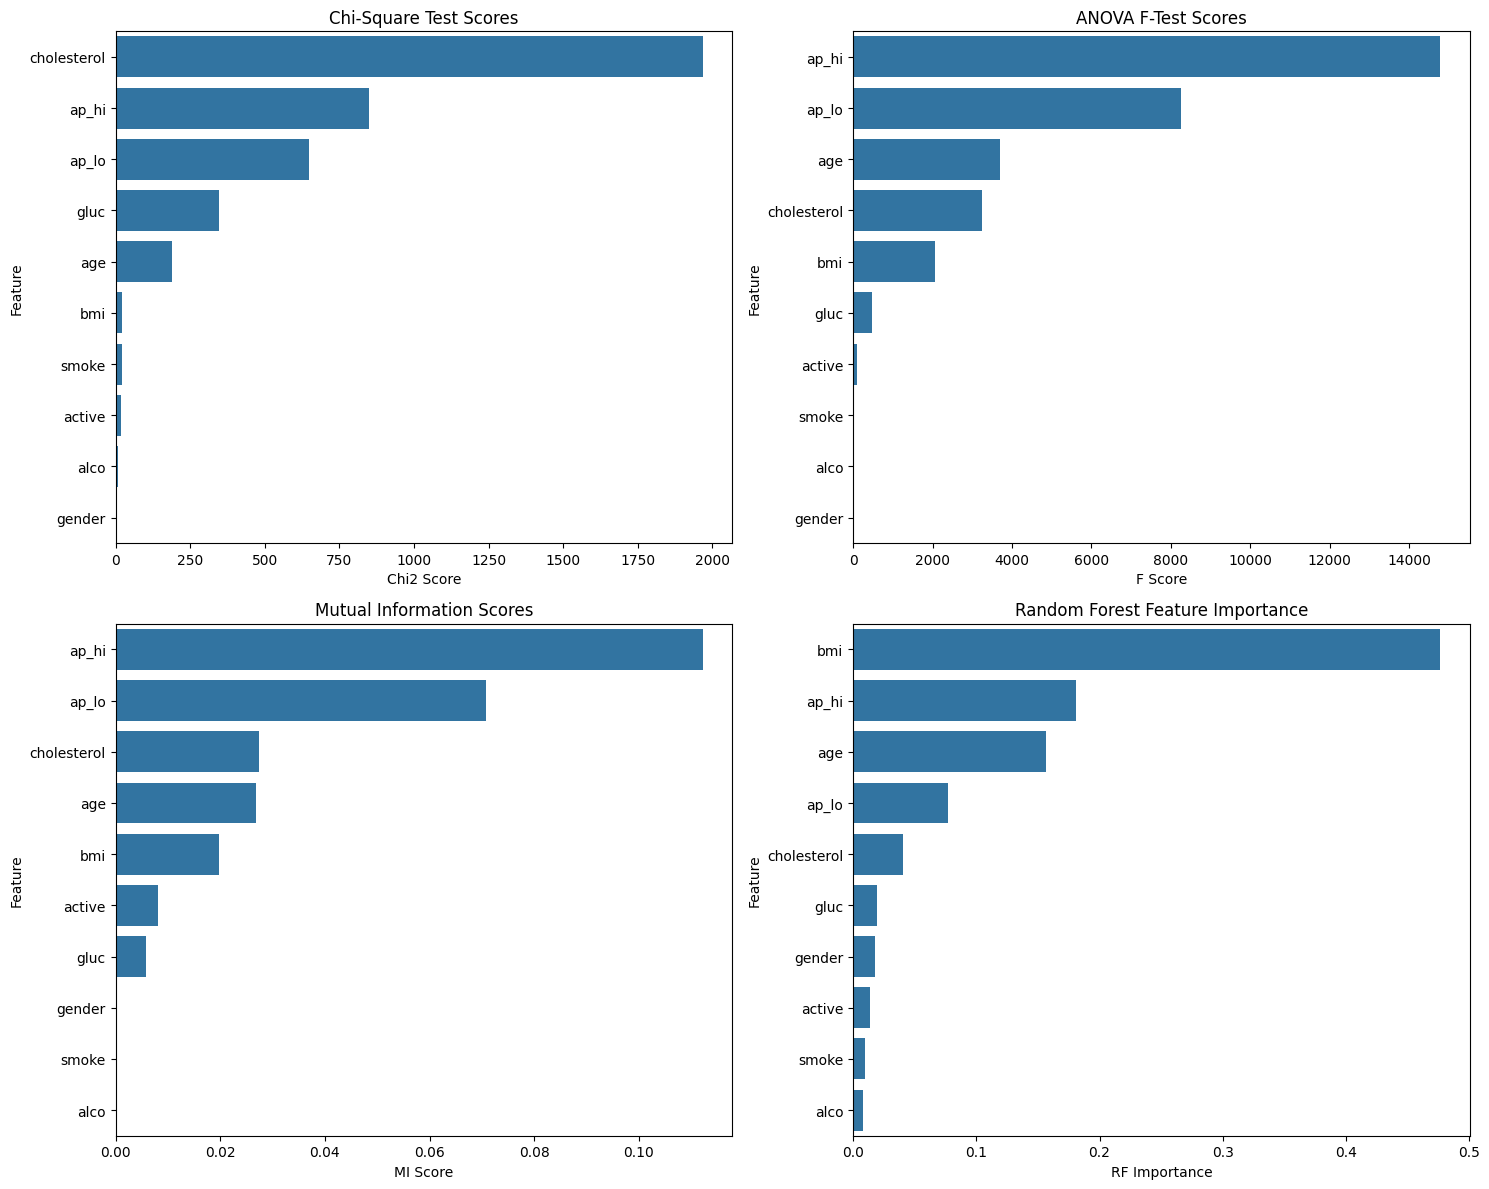

In [6]:
def perform_feature_selection(X, y):
    """
    Perform multiple feature selection methods on cardiovascular disease data
    
    Parameters:
    X (DataFrame): Feature matrix
    y (Series): Target variable
    
    Returns:
    dict: Dictionary containing selected features from each method
    """
    results = {}
    
    # 1. Normalize features for chi-square test
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # 2. Chi-square test
    chi_selector = SelectKBest(chi2, k=5)
    chi_selector.fit(X_scaled, y)
    chi_scores = pd.DataFrame({
        'Feature': X.columns,
        'Chi2 Score': chi_selector.scores_
    }).sort_values('Chi2 Score', ascending=False)
    results['chi_square'] = chi_scores
    
    # 3. ANOVA F-test
    f_selector = SelectKBest(f_classif, k=5)
    f_selector.fit(X, y)
    f_scores = pd.DataFrame({
        'Feature': X.columns,
        'F Score': f_selector.scores_
    }).sort_values('F Score', ascending=False)
    results['anova'] = f_scores
    
    # 4. Mutual Information
    mi_selector = SelectKBest(mutual_info_classif, k=5)
    mi_selector.fit(X, y)
    mi_scores = pd.DataFrame({
        'Feature': X.columns,
        'MI Score': mi_selector.scores_
    }).sort_values('MI Score', ascending=False)
    results['mutual_info'] = mi_scores
    
    # 5. Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_scores = pd.DataFrame({
        'Feature': X.columns,
        'RF Importance': rf.feature_importances_
    }).sort_values('RF Importance', ascending=False)
    results['random_forest'] = rf_scores
    
    # 6. Recursive Feature Elimination
    rfe = RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=5)
    rfe.fit(X, y)
    rfe_scores = pd.DataFrame({
        'Feature': X.columns,
        'Selected': rfe.support_
    })
    results['rfe'] = rfe_scores
    
    return results

def plot_feature_importance(results):
    """
    Plot feature importance scores from different methods
    
    Parameters:
    results (dict): Dictionary containing feature selection results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot Chi-square scores
    sns.barplot(data=results['chi_square'].head(10), 
                x='Chi2 Score', y='Feature', ax=axes[0,0])
    axes[0,0].set_title('Chi-Square Test Scores')
    
    # Plot ANOVA F-scores
    sns.barplot(data=results['anova'].head(10), 
                x='F Score', y='Feature', ax=axes[0,1])
    axes[0,1].set_title('ANOVA F-Test Scores')
    
    # Plot Mutual Information scores
    sns.barplot(data=results['mutual_info'].head(10), 
                x='MI Score', y='Feature', ax=axes[1,0])
    axes[1,0].set_title('Mutual Information Scores')
    
    # Plot Random Forest importance
    sns.barplot(data=results['random_forest'].head(10), 
                x='RF Importance', y='Feature', ax=axes[1,1])
    axes[1,1].set_title('Random Forest Feature Importance')
    
    plt.tight_layout()
    return fig

# Example usage:

# Contoh penggunaan:
results = perform_feature_selection(X, y)
fig = plot_feature_importance(results)
plt.show()

# Mendapatkan fitur terpenting berdasarkan Random Forest
top_features_rf = results['random_forest'].head(5)['Feature'].tolist()


In [6]:
X = X.loc[:, ['ap_hi', 'ap_lo', 'cholesterol', 
                'gluc', 'map'
                ]]
X.head()

KeyError: "['map'] not in index"

### **Scaling Data**

In [15]:
standard_features = ['age', 'height', 'weight','ap_hi', 'ap_lo']
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

assert all(feature in X.columns for feature in standard_features + categorical_features)



AssertionError: 

In [8]:
scaler_standard = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard', scaler_standard, standard_features)
    ],
    remainder='passthrough'  # Biarkan fitur kategorikal/biner tidak berubah
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_preprocessed = pipeline.fit_transform(X)

X_preprocessed = pd.DataFrame(X_preprocessed, columns=standard_features + categorical_features)
X_preprocessed

ValueError: Shape of passed values is (64469, 12), indices imply (64469, 11)

### **Train, Val, Test**

In [12]:
# x_train, x_temp, y_train, y_temp = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)  # Train 70%
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=(1/3), random_state=42)  # Val 20%, Test 10%

x_train, x_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)  # Train 70%

In [13]:
# NumPy array format
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

In [17]:
# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(x_train, y_train)

# Make predictions
y_pred = rf_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.68


In [33]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform Grid Search
grid_search.fit(x_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f'Best Parameters: {best_params}')

# Evaluate the best model
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

In [16]:
# Create the K-Nearest Neighbors model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(x_train, y_train)

# Make predictions
y_pred = knn_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


In [17]:
# Define the objective function for Optuna
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    scores = cross_val_score(knn_model, x_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print(f'Best Parameters: {best_params}')

# Train the model with the best parameters
best_knn_model = KNeighborsClassifier(**best_params)
best_knn_model.fit(x_train, y_train)

# Make predictions
y_pred = best_knn_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Best Parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'euclidean'}
Accuracy: 0.71


In [39]:
# Create the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.72


In [50]:
# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Perform manual split for validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        x_train, y_train, test_size=0.2, random_state=trial.number
    )

    xgb_model.fit(X_train_split, y_train_split)
    y_pred_split = xgb_model.predict(X_val_split)
    accuracy = accuracy_score(y_val_split, y_pred_split)

    return accuracy

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print(f'Best Parameters: {best_params}')

# Train the model with the best parameters
best_xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Best Parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.10476950755126394, 'subsample': 0.9321888883099256, 'colsample_bytree': 0.8165079819687229}
Accuracy: 0.72


In [53]:
# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(x_train, y_train)

# Make predictions
y_pred = dt_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.63


In [ ]:
base_model_ebc = ExplainableBoostingClassifier()

base_model_ebc.fit(x_train, y_train)

y_pred = base_model_ebc.predict(x_train)

accuracy = accuracy_score(y_train, y_pred)
print(f"EBC Accuracy: {accuracy:.4f}")

EBC Accuracy: 0.7327


In [19]:
base_model_ebc = ExplainableBoostingClassifier()

base_model_ebc.fit(x_train, y_train)

y_pred = base_model_ebc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"EBC Accuracy: {accuracy:.4f}")

EBC Accuracy: 0.7307
